## FieldTrip sample data example
In this example we show processing of primate single unit data made available in FieldTrip spike tutorial (https://www.fieldtriptoolbox.org/tutorial/spike/).   

In [1]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import pylabianca as pln

We will read fieldtrip sample data and perform similar analyses to the fieldtrip spike-analysis tutorial. The data used here is the plexon nex file used in the fieldtrip spike tutorial saved as fieldtrip matlab format. You can download the matlab-format file used here from [this link](https://www.dropbox.com/scl/fo/i6q4e0ix805dds92jibmw/h?rlkey=cfdm1730qubqwb64zj1j02tvt&dl=0).  
Note that you can also download the original plexon nex file from the fieldtrip website and read it using `pln.io.read_plexon_nex()` function.

In [2]:
data_dir = r'C:\Users\Asus\Dropbox\Sarenka\PROJECTS\pylabianca\ft_data'
fname = 'p029_sort_final_01.mat'
full_path = op.join(data_dir, fname)

spk = pln.io.read_fieldtrip(full_path)

Let's see a simple text description of the file.

In [3]:
spk

<Spikes, 21 cells, 201757.0 spikes/cell on average>

This is raw (non-epoched) data object with spikes information.    
Let's take a look at the unit names, this is stored in `.cell_names` property:

In [4]:
spk.cell_names

array(['sig001U', 'sig001a', 'sig002U', 'sig002a', 'sig003U', 'sig003a',
       'sig004U', 'sig001U_wf', 'sig001a_wf', 'sig002U_wf', 'sig002a_wf',
       'sig003U_wf', 'sig003a_wf', 'sig004U_wf', 'sig001U', 'sig001a',
       'sig002U', 'sig002a', 'sig003U', 'sig003a', 'sig004U'],
      dtype=object)

We will select a subset of units that contain waveform information. These units have `'_wf'` in their name.  
We will first collect the names of the units that we want to select (those with `'_wf'` in their name) and then use `.pick_cells()` method. This method works in place (so it will modify our `spk` object) and selects units either by their names or indices.

In [5]:
picks = [name for name in spk.cell_names if '_wf' in name]
spk.pick_cells(picks)

<Spikes, 7 cells, 302635.0 spikes/cell on average>

We will first take a look at the inter-spike intervals (ISI) of these units. We can use `pln.viz.plot_isi()` function for that. First we will do it for one unit only (using `picks` argument to specify unit name of index):

<Axes: title={'center': 'sig001U_wf'}, xlabel='ISI (ms)', ylabel='Count'>

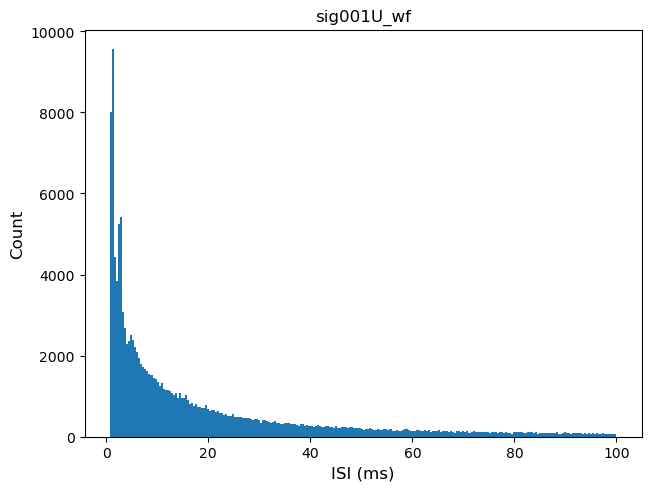

In [6]:
pln.viz.plot_isi(spk, picks=0)

The ISI histogram above suggests that it is a multiunit (many refractory period violations).  
We can plot ISI histograms for multiple units at once by providing a list or array of unit names / unit indices to `picks`.  
When we do not specify the `picks`, the function will try to plot histograms for all units. Below we also reduce the number of bins in the histograms (`bins=75`):

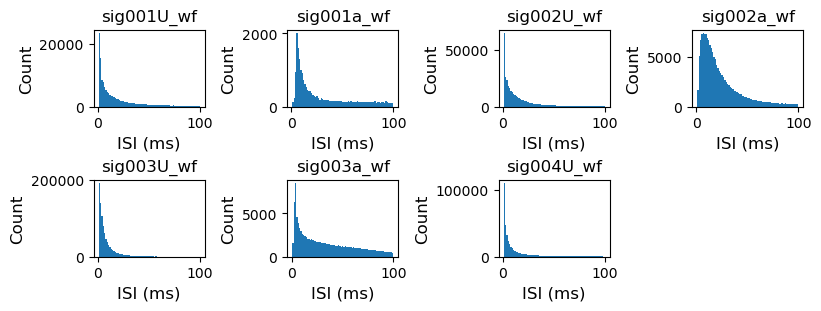

In [7]:
pln.viz.plot_isi(spk, bins=75);

Loking at the ISI histograms we can see that units with "U" in their file name are multi-units - they do not display a dip in ISI count towards 2-3 ms and thus violate the refractory period that a single neuron would manifest. 
we can see that for this dataset  
Let's look at waveform for the single units:

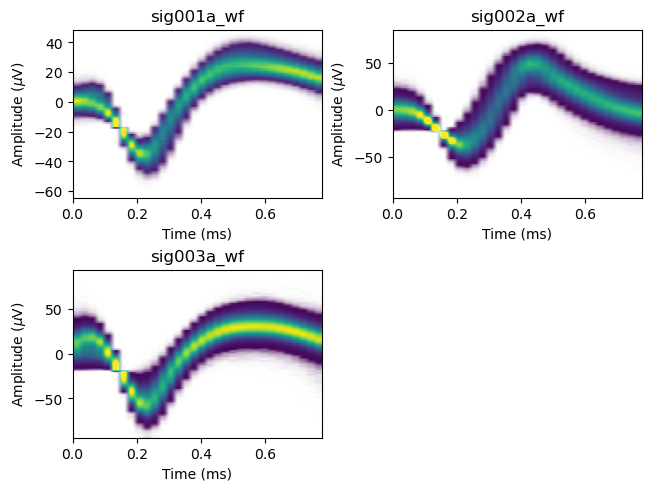

In [8]:
single_units = [name for name in spk.cell_names if not name.endswith('U_wf')]
spk.plot_waveform(picks=single_units);

We can see that waveforms for the sample fieldtrip spike data are not peak-aligned. We can realign them using `pln.utils.realign_wavefroms()`. This function also does some simple cleaning of the waveforms - rejecting the waveforms and corresponding spikes that are clearly incorrect (inspired by what is done by FieldTrip's `ft_spike_waveform`):

In [9]:
pln.utils.realign_waveforms(spk, picks=single_units)

Removing 723 bad waveforms for cellsig002a_wf.
Removing 28 bad waveforms for cellsig003a_wf.


(realigning waveforms works in-place, so out Spikes object (`spk`) is modified now)

When plotting the waveforms by default they are shown in their original resolution - 32 samples each in the case here. We can upsample the waveforms to get a cleaner picture using `upsample` argument:

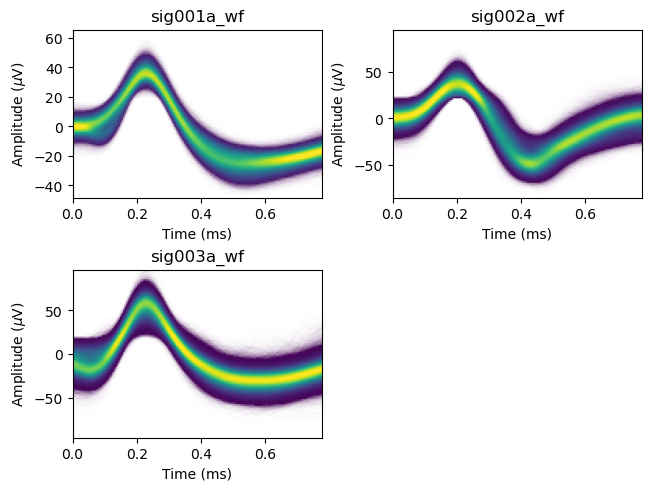

In [10]:
ax = spk.plot_waveform(picks=single_units, upsample=5);

### Epoching Spikes
We will now read events from the original `.nex` file and epoch the spikes around these events. Epoching is just selecting data within some time limits around the events. In the context of spike times, epoching will turn these times from timestamps to time (in seconds) relative to the event onset.

In [13]:
event_fname = 'p029_sort_final_01.nex'
events = pln.io.read_events_plexon_nex(op.join(data_dir, event_fname))

The events are organized in the default mne-python format: first column stores sample index (here timestamp), last column - event id (middle column is not used in this context):

In [14]:
events[:10]

array([[111204,      0,  10044],
       [111283,      0,      1],
       [111363,      0,  20001],
       [111444,      0,  10000],
       [121562,      0,  10001],
       [121642,      0,  10002],
       [121722,      0,  10003],
       [121802,      0,  10033],
       [121882,      0,  10008],
       [132001,      0,  10009]])

We can use `.epoch()` method of `Spikes` to create `SpikeEpochs` - a data representation with multiple trials centered with respect to some event of interest  
According to FieldTrip tutorial trigger `10030` is referred to as "stimon" in the fieldtrip example - so it is stimulus onset. We now epoch the spikes with respect to this event:

In [15]:
spk_epochs = spk.epoch(events, event_id=10030, tmin=-0.5, tmax=1.)

We can now calculate peri-stimulus spike density. We specify the length of the gaussian kernel using full width at half-maximum (`fwhm` argument), but there are other ways to do so (`gauss_sd` and `windlen` - for more details see the docstring of `.spike_density()` method): 

In [16]:
frate = spk_epochs.spike_density(fwhm=0.1)

Because the output of `.spike_density()` (and `.spike_rate()`, another spike rate counting method), is an xarray DataArray, we can use various convenient plotting options of xarray to visualize firing rate changes.  
Xarray arrays have named dimensions, so below you can see that when we take the mean of the trial dimension, we don't have to remember its numerical order, but just specify the dimension name (`.mean(dim='trial')`). After taking the mean `.plot()` method is used and the averages are plotted using different color for each cell (`hue='cell'`):

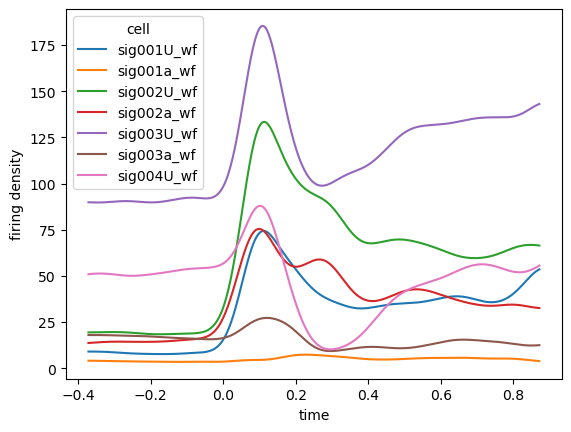

In [17]:
frate.mean(dim='trial').plot(hue='cell');

We can also first select a single cell by index (using the `.isel()` method) and then plot single-trial firing rate as a heatmap:

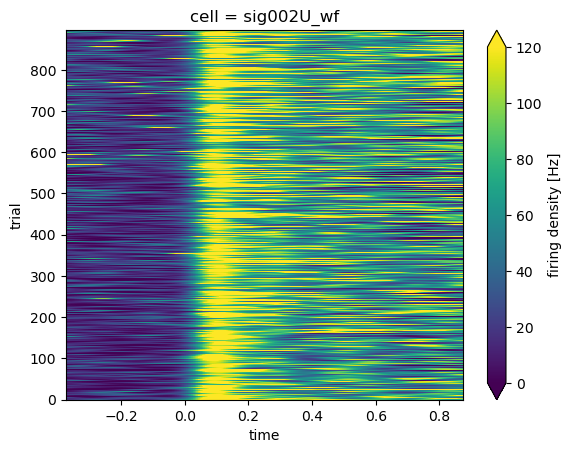

In [18]:
frate.isel(cell=2).plot(vmin=0, vmax=120);

or as separate lines:

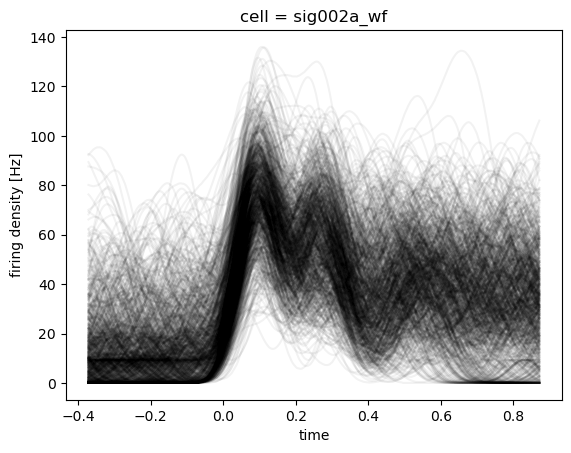

In [19]:
frate.isel(cell=3).plot(hue='trial', color='k', alpha=0.05, add_legend=False);

To plot the spiking with standard error of the mean shade we can use `pln.viz.plot_shaded`:

<Axes: title={'center': 'cell = sig001a_wf'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

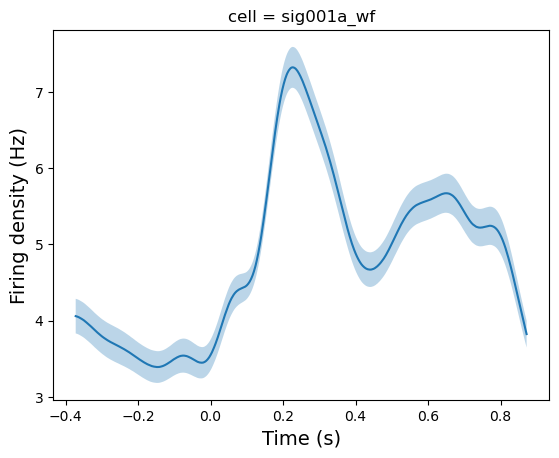

In [20]:
pln.viz.plot_shaded(frate.isel(cell=1))

<Axes: title={'center': 'cell = sig002a_wf'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

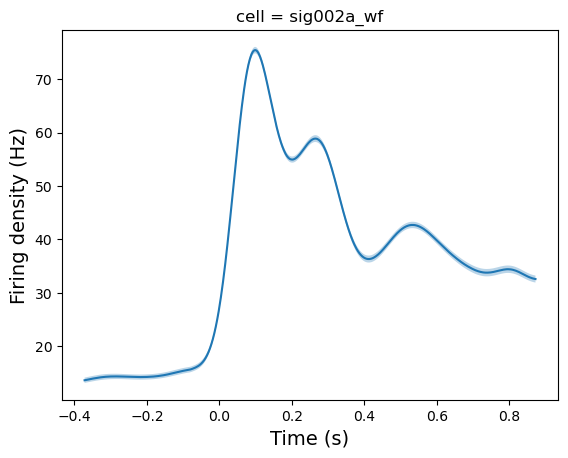

In [21]:
pln.viz.plot_shaded(frate.isel(cell=3))

### adding condition information
We will now add information about the conditions. The conditions are encoded in the values of the events, but in the case of this dataset the conditions have to be extracted by looking at multiple events around stimulus onset. To simplify this example we've already extracted the condition information and saved it as a table in a separate csv file (`'monkey_stim.csv'`). To see how we've extracted this information take a look at the `testing_fieldtrip_events.py` file shared [here](https://www.dropbox.com/scl/fo/i6q4e0ix805dds92jibmw/h?rlkey=cfdm1730qubqwb64zj1j02tvt&dl=0).  
Often, the experimental procedure will save such table so that reading condition information is as simple as reading a file. 

In [22]:
import pandas as pd

metadata = pd.read_csv(op.join(data_dir, 'monkey_stim.csv'))

Before we set this table as metadata of `SpikeEpochs` object, we will make sure that the number of rows in the table matches the number of trials in the `SpikeEpochs` object:

In [24]:
print('number of trials in SpikeEpochs: ', spk_epochs.n_trials)
print('number of rows in the condtion information table', metadata.shape[0])

number of trials in SpikeEpochs:  897
number of rows in the condtion information table 1028


The mismatch stems from the fact that the table contains information about all trials, while the `SpikeEpochs` object was created by epoching with respect to the stimulus onset. However, some trials did not contain stimulus presentation (likely due to monkey responding too early). We will select only the rows of the metadata table corresponding to the trials with stimulus presentation:

In [26]:
metadata_epochs = metadata.query('has_stimon == True')

Now we can set the table as metadata for the SpikeEpochs object:

In [27]:
spk_epochs.metadata = metadata_epochs

### Plotting with condtion information

We can calculate the firing rate again - but now the xarray will inherit all the condition information.

In [29]:
frate = spk_epochs.spike_density(fwhm=0.1)

Let's first compare firing rate in correct and incorrect trials for the first cell: 

<Axes: title={'center': 'cell = sig001U_wf'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

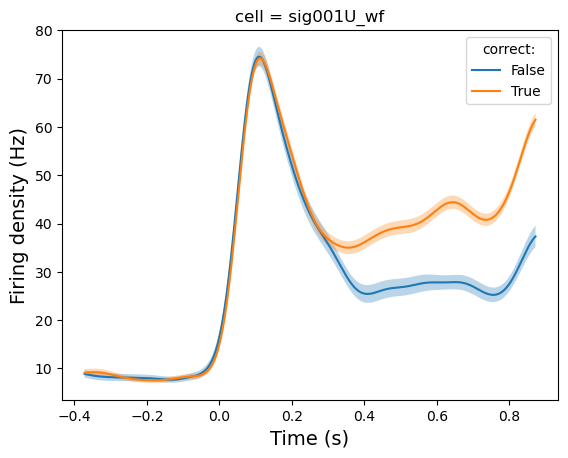

In [30]:
pln.viz.plot_shaded(frate.isel(cell=0), groupby='correct')

or the effect of attention on correct trials. We will select only the correct trials from the firing rate xarray and then plot using `groupby='attention'`:

<Axes: title={'center': 'cell = sig001U_wf'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

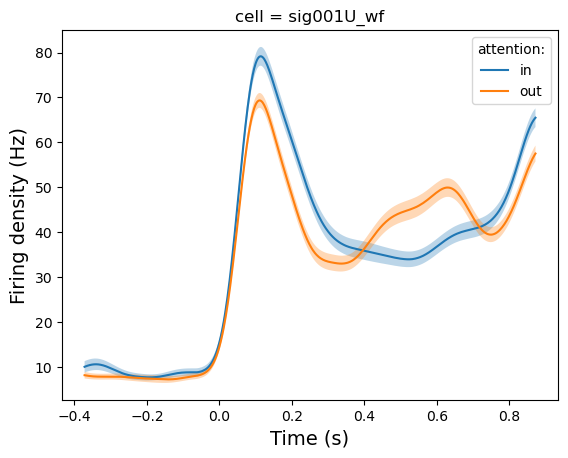

In [31]:
frate_correct = frate.query({'trial': 'correct == 1'})
pln.viz.plot_shaded(frate_correct.isel(cell=0), groupby='attention')

We can easily compute cluster-based permutation test to see if this difference is significant:

In [32]:
stats, clusters, pval = pln.stats.cluster_based_test(
    frate_correct.isel(cell=0), compare='attention')

c:\src\borsar\borsar\freq.py:19: FutureWarning: mne.io.meas_info.ContainsMixin is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.meas_info import ContainsMixin
100%|██████████| 1000/1000 [00:07<00:00, 132.83it/s]


let's see cluster-level p values:

In [33]:
pval

array([0.   , 0.   , 0.118])

We see that cluster-level p value is < .05 in two cases. The difference between conditions can be judged as statistically significant. To visualise these clusters, and attached cluster-level p value, we will use `pln.viz.add_highlights()`:

<Axes: title={'center': 'cell = sig001U_wf'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

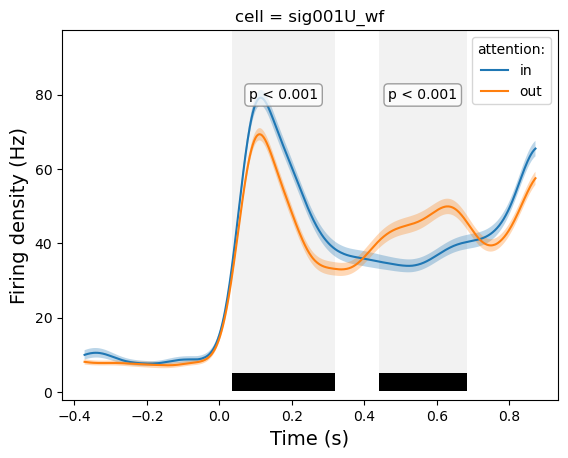

In [34]:
pln.viz.plot_shaded(frate_correct.isel(cell=0), groupby='attention')
pln.viz.add_highlights(frate_correct.isel(cell=0), clusters, pval)

## Raster plots
A common way of visualizing spike data is to use raster plots. We can use `pln.viz.plot_raster()` to plot raster plots. We can also use this function to include condtion information in the plot:

<Axes: xlabel='Time (s)', ylabel='Trial'>

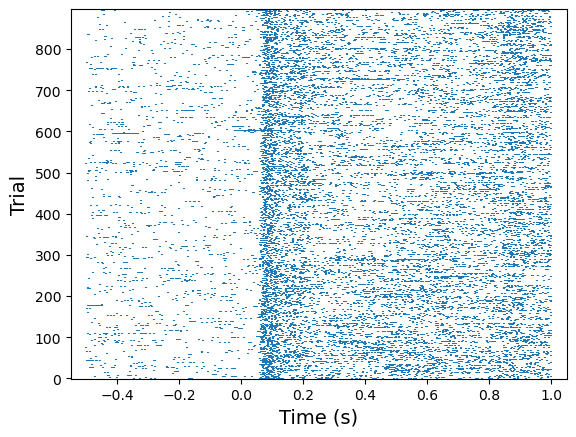

In [35]:
pln.viz.plot_raster(spk_epochs, pick=0)

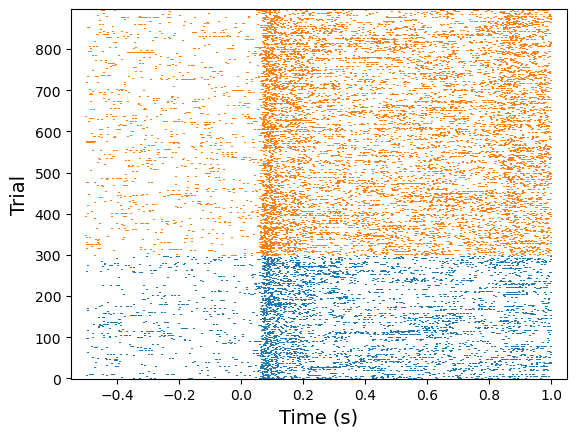

In [36]:
ax = pln.viz.plot_raster(spk_epochs, pick=0, groupby='correct')

## Cross-correlations
We can also take a look at pre-stimulus (or post-stimulus) auto / cross-correlations. We will only shortly showcase how to perform and visualise cross-correlations here.
We can compute cross-correlations by using `.xcorr()` method of SpikeEpochs:

In [37]:
spk_epo_prestim = spk_epochs.copy().crop(tmin=-0.5, tmax=0)

In [52]:
xcr = spk_epo_prestim.xcorr(gauss_fwhm=0.005)

The output of `.xcorr()` is an xarray DataArray. Each element along the cell dimension corresponds to a cell pair (so depending on whether the cells in the pair are same or different we have auto- or cross-correlation).

<Axes: title={'center': 'cell = sig001a_wf x sig001a_wf, cell1_name = si...'}, xlabel='Lag (s)', ylabel='Count'>

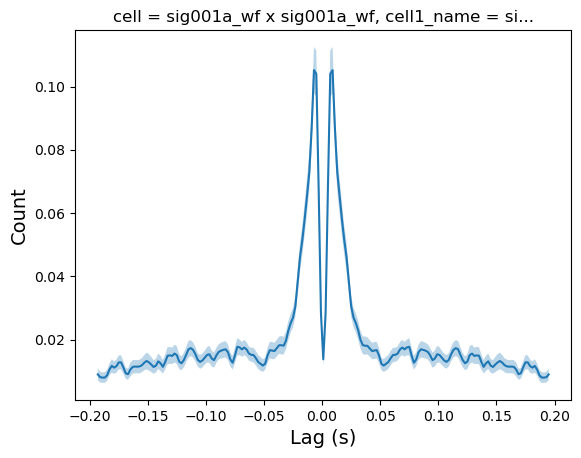

In [53]:
pln.viz.plot_shaded(xcr.isel(cell=8))

<Axes: title={'center': 'cell = sig001a_wf x sig003U_wf, cell1_name = si...'}, xlabel='Lag (s)', ylabel='Count'>

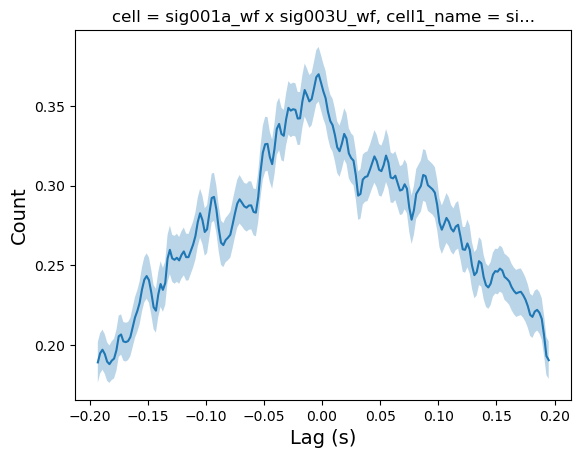

In [57]:
pln.viz.plot_shaded(xcr.isel(cell=11))